# Forest sub-model - Notebook 1

* **Products used:** 
[cgls_landcover](https://explorer.digitalearth.africa/products/cgls_landcover)

## Background

This notebook calculates and stores the first sub-model in the elephant Habitat Suitability Model; the forest sub-model. It has the data layers and weightings listed in the table below. 

Data layer | Layer weighting |
-----------: | -----------: |
Closed forest evergreen (CGLS 111 & 112) | 16.7% | 
Closed forest mixed (CGLS 115 & 116) | 16.7% |
Open forest evergreen (CGLS 121 & 122) | 16.7% | 
Open forest deciduous (CGLS 123 & 124) | 16.7% |
Closed forest deciduous (CGLS 113 & 114) | 16.7% |
Open forest mixed (CGLS 125 & 126) | 16.7% |


The notebook executes the following steps:

   1. Load landcover CGLS data and select the relevant forest layers.
   2. Within the area of interest, calculate distance to forest layers quantified as euclidean distance in metres.
   3. Standardise the euclidean distance measure so it ranges between 0 and 1.
   4. Use a weighted linear combination approach to estimate habitat suitability from a forest cover perspective.

### Load packages
Import Python packages that are used for the analysis, including a package for calculating euclidean distance.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
from deafrica_tools.plotting import plot_lulc

try:
      import xrspatial
except:
      !pip install xrspatial
    
from xrspatial import proximity

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app='Elephant-HSM-forest')

## Load CGLS landcover

A query is defined in this notebook then stored for subsequent notebooks. This ensures data layers and sub-models can be combined in the final model. Note that the first line is where you can set the resolution of the dataset.

In [3]:
#create reusable datacube query object
resolution=(-200, 200) 

measurements='classification'

%store -r lons
%store -r lats

query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'time': ('2019'),
    'output_crs': 'epsg:6933',
    'measurements':measurements
}

%store query

ds_cgls = dc.load(product='cgls_landcover', **query).squeeze()

Stored 'query' (dict)


## Visualise land cover

Let's inspect the distribution of land cover classes in the area of interest before isolating the forest classes.

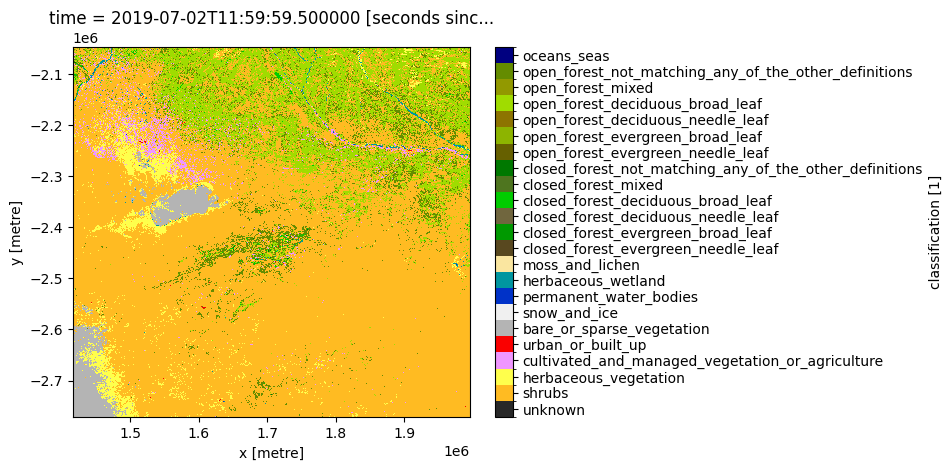

In [4]:
plot_lulc(ds_cgls.classification, product="CGLS", legend=True)

# Forest layers

Now we'll isolate relevant forest layers to calculate euclidean distance.

## Closed forest evergreen

We can see in the table at the beginning of the notebook that closed forest evergreen relates to CGLS bands 111 and 112.

In [5]:
cgls_cfe = ds_cgls.where((ds_cgls==111) | (ds_cgls==112))

The below cell calculates the euclidean distance from the identified land cover type for each cell. It can be interpreted as the distance in metres from the nearest 'closed forest evergreen'.

In [6]:
proximity_cfe = proximity(cgls_cfe.classification, distance_metric = 'EUCLIDEAN')

Next, the distance layer is standardised to range between 0 and 1. We use `1 - distance` in this case because forests are considered desirable habitat, so forest areas are assigned a value of 1 while areas far from forest have values closer to 0.

There are no areas of class 'closed forest evergreen' in the default area of interest, so this layer is assigned to `0` values.

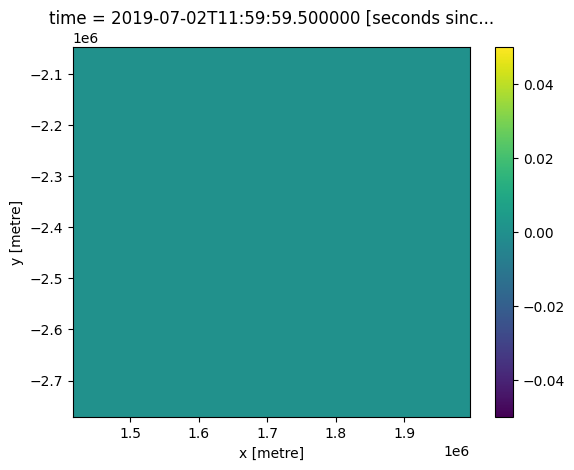

In [7]:
cfe_proximity_std = 1 - (proximity_cfe/np.max(proximity_cfe))
cfe_proximity_std = cfe_proximity_std.fillna(0)
cfe_proximity_std.plot()

## Closed forest mixed

The process is repeated for the 'closed forest mixed' class. In this case, we can see a few areas of 'closed forest mixed' dotted in the centre of the plot below.

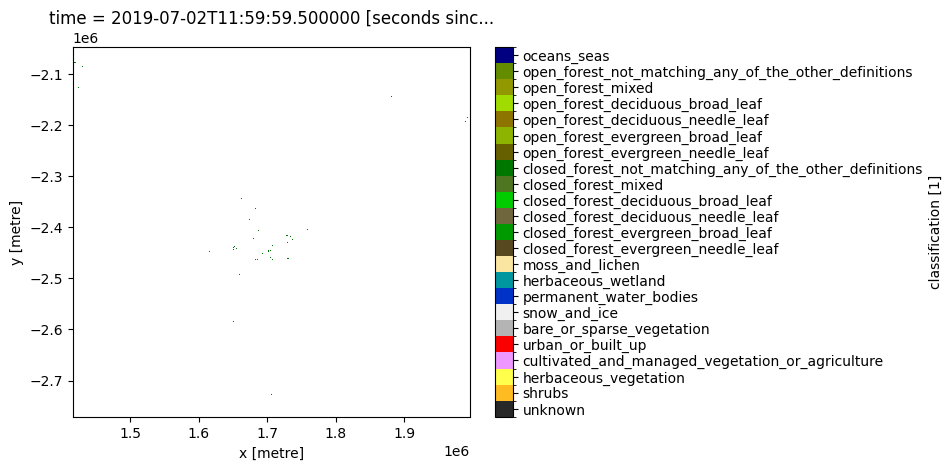

In [8]:
plot_lulc(ds_cgls.where((ds_cgls==115)|(ds_cgls==116)).classification, product="CGLS", legend=True)

Now the euclidean distance is calculated and standardised. We can see in the plot below that areas corresponding to 'closed forest mixed' have values close to or equal to 1, whereas areas furthest from the land cover class have values closer to 0. This confirms that the process is working as expected.

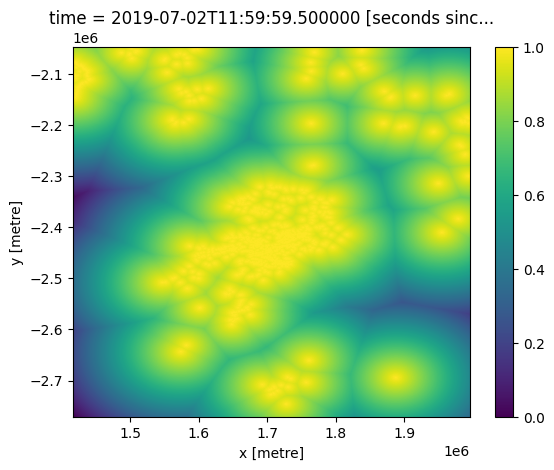

In [9]:
cgls_cfm = ds_cgls.where((ds_cgls==115)|(ds_cgls==116))

cfm_proximity = proximity(cgls_cfm.classification, distance_metric='EUCLIDEAN')

cfm_proximity_std = 1 - (cfm_proximity/np.max(cfm_proximity))

cfm_proximity_std = cfm_proximity_std.fillna(0)
cfm_proximity_std.plot()

## Open forest evergreen

The process is repeated for the 'open forest evergreen' class. In the default area of interest there are no instances of this class, so again the layer is assigned to 0 values.

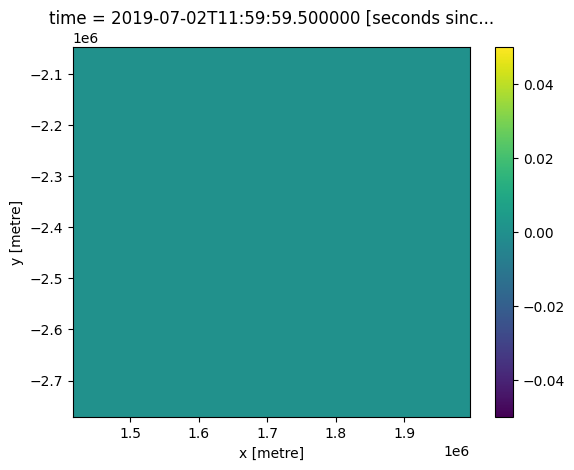

In [10]:
cgls_ofe = ds_cgls.where((ds_cgls==121) | (ds_cgls==122))
ofe_proximity = proximity(cgls_ofe.classification, distance_metric = 'EUCLIDEAN')

ofe_proximity_std = 1 - (ofe_proximity/np.max(ofe_proximity))

ofe_proximity_std = ofe_proximity_std.fillna(0)
ofe_proximity_std.plot()

## Open forest deciduous

There is a lot of 'open forest deciduous' in the north-east of the default area of interest.

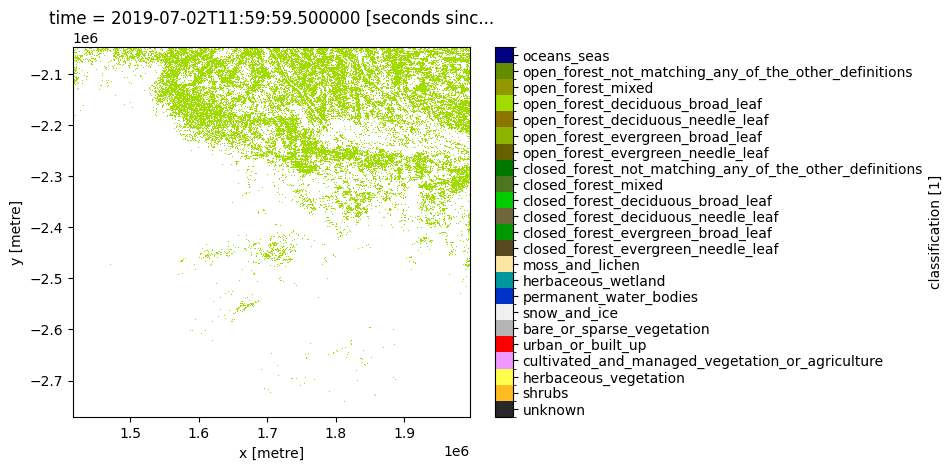

In [11]:
plot_lulc(ds_cgls.where((ds_cgls==123)|(ds_cgls==124))[measurements], product="CGLS", legend=True)

We can see the distance plot corresponds to the distribution of 'open forest deciduous' above.

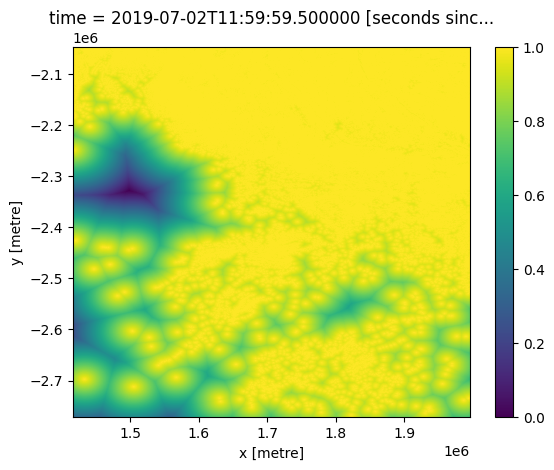

In [12]:
cgls_ofd = ds_cgls.where((ds_cgls==123)|(ds_cgls==124))
ofd_proximity = proximity(cgls_ofd.classification, distance_metric = 'EUCLIDEAN')

ofd_proximity_std = 1 - (ofd_proximity/np.max(ofd_proximity))

ofd_proximity_std = ofd_proximity_std.fillna(0)
ofd_proximity_std.plot()

## Closed forest deciduous

The process is repeated again below for the 'closed forest deciduous' class, which is scattered throughout the default area of interest.

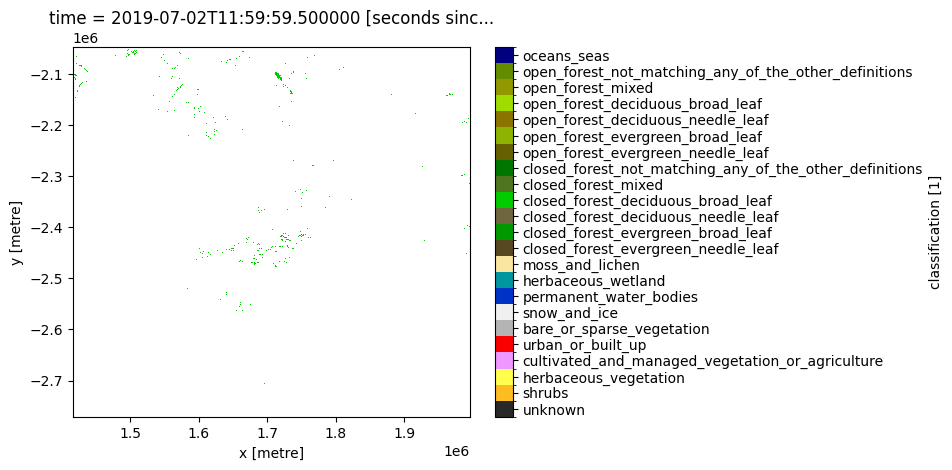

In [13]:
plot_lulc(ds_cgls.where((ds_cgls==113)|(ds_cgls==114))[measurements], product="CGLS", legend=True)

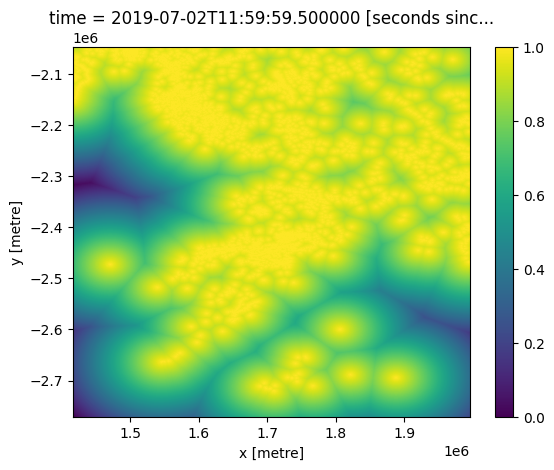

In [14]:
cgls_cfd = ds_cgls.where((ds_cgls==113)|(ds_cgls==114))

cfd_proximity = proximity(cgls_cfd.classification, distance_metric = 'EUCLIDEAN')

cfd_proximity_std = 1 - (cfd_proximity/np.max(cfd_proximity))

cfd_proximity_std = cfd_proximity_std.fillna(0)
cfd_proximity_std.plot()

## Open forest mixed

'Open forest mixed' is the final layer in the forest sub-model.

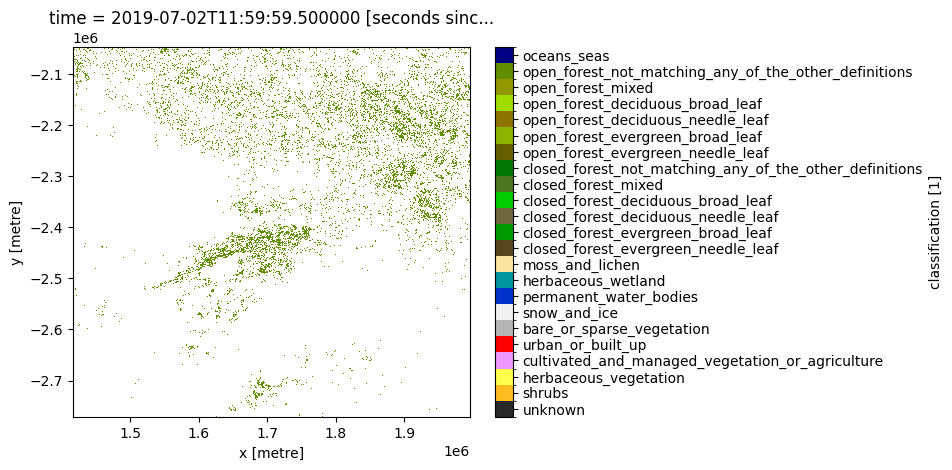

In [15]:
plot_lulc(ds_cgls.where((ds_cgls==125)|(ds_cgls==126))[measurements], product="CGLS", legend=True)

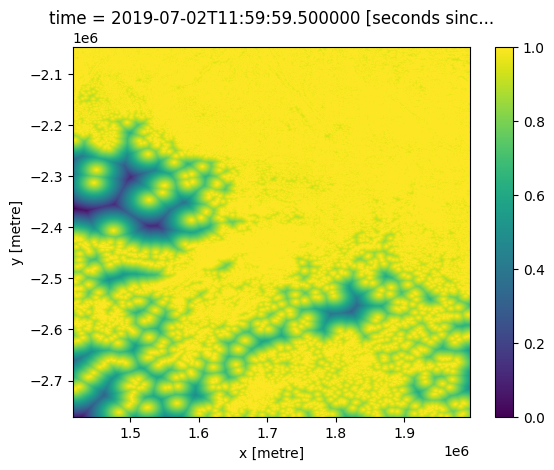

In [16]:
cgls_ofm = ds_cgls.where((ds_cgls==125)|(ds_cgls==126))

ofm_proximity = proximity(cgls_ofm.classification, distance_metric = 'EUCLIDEAN')

ofm_proximity_std = 1 - (ofm_proximity/np.max(ofm_proximity))

ofm_proximity_std = ofm_proximity_std.fillna(0)
ofm_proximity_std.plot()

# Weighted Linear Combination

Now that all the forest layers have been processed and standardised, we can combine them using weighted linear combination to produce the forests sub-model.

## Weights

The table at the beginning of the notebook shows that all six forest layers are weighted equally at 16.67% in this sub-model.

In [17]:
weight = 0.1667

## Calculate WLC

The Weighted Linear Combination calculation is performed by multiplying each forest layer by the weight and adding the results.

We can see that the sub-model generally reflects the distribution of forested land cover in the area of interest.

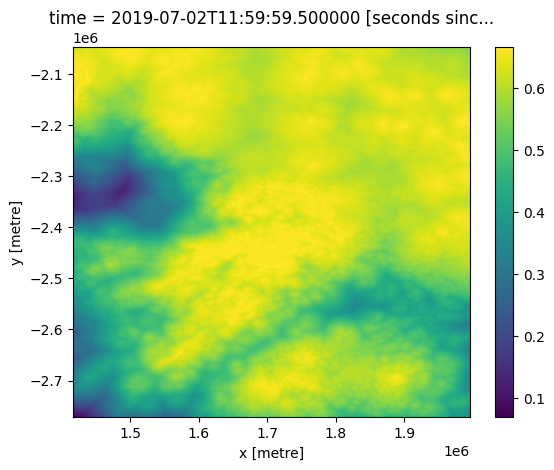

In [18]:
forest_model=(cfe_proximity_std*weight)+(
    cfm_proximity_std*weight)+(
    ofe_proximity_std*weight)+(
    ofd_proximity_std*weight) + (
    cfd_proximity_std*weight) + (
    ofm_proximity_std*weight)

forest_model.plot()

## Save to outputs

Finally, the forest sub-model is saved to the outputs folder so we can bring it in when we calculate the final habitat suitability model.

In [19]:
forest_model = forest_model.drop('time', dim=None)
forest_model.to_netcdf('outputs/forest_sm.nc')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [20]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [21]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-04-20'